In [1]:
#@title Importing libraries (double-click to show code)
import os
import pkg_resources
pkg_resources.require("numpy>=`1.20.1")  #  to use specific numpy version
import numpy as np
import rsnapsim as rss
import sys
from sys import platform
from skimage import io ; from skimage.io import imread; from skimage.measure import find_contours
from random import randrange
import pandas as pd
import os; from os import listdir; from os.path import isfile, join
import re
import shutil
import pathlib
from pathlib import Path
from random import randrange
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout 
from IPython.display import Image
import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord
import tqdm.notebook as tq

# Defining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

masks_dir = current_dir.parents[1].joinpath('DataBases','masks_for_sim_cell')

# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp
import matplotlib

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = False


In [2]:
# Plasmid sequences
gene_file_pUB_SM_KDM5B_PP7 = str(sequences_dir.joinpath('pUB_SM_KDM5B_PP7.gb')) # plasmid pUB_SM_KDM5B_PP7 
gene_file_pUB_SM_p300_MS2 = str(sequences_dir.joinpath('pUB_SM_p300_MS2.gb')) # plasmid pUB_SM_p300_MS2

# Coding sequence
gene_file_KDM5B_PP7 = str(sequences_dir.joinpath('pUB_SM_KDM5B_PP7_coding_sequence.txt')) # coding sequence for SM_KDM5B_PP7    ### 5685 nt   ### 1895 codons
gene_file_p300_MS2 = str(sequences_dir.joinpath('pUB_SM_p300_MS2_coding_sequence.txt'))  # coding sequence for SM_p300_MS2      ### 8268 nt   ### 2756 codons

In [3]:
from dna_features_viewer import BiopythonTranslator
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator
    """
    def compute_feature_color(self, feature):
        if feature.type == "CDS":
            return "#57B956"
        elif feature.type == "FLAG":
            return "#57B956"
        elif feature.type == "MS2":
            return "#098BF5"
        elif feature.type == "PP7": 
            return "#EB5559"
        else:
            return "#C4B07B"

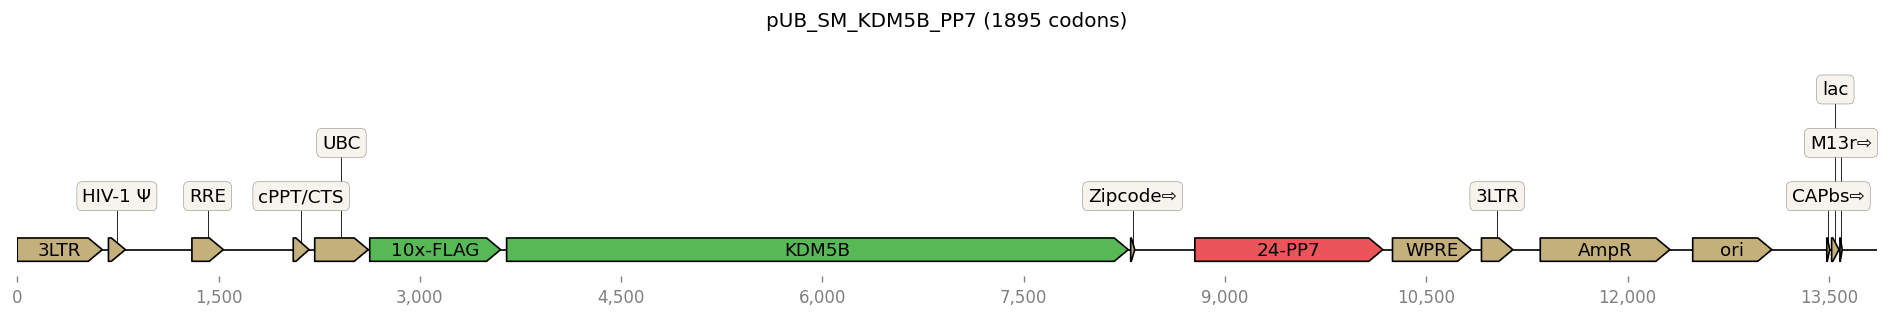

In [4]:
graphic_record = MyCustomTranslator().translate_record(gene_file_pUB_SM_KDM5B_PP7) 
ax, _ = graphic_record.plot(figure_width=20, strand_in_label_threshold=7)
ax.set_title('pUB_SM_KDM5B_PP7 (1895 codons)')
graphic_record.plot_legend(ax=ax, loc=1, ncol=3, frameon=False)
#ax.figure.savefig("pUB_SM_KDM5B_PP7.png")

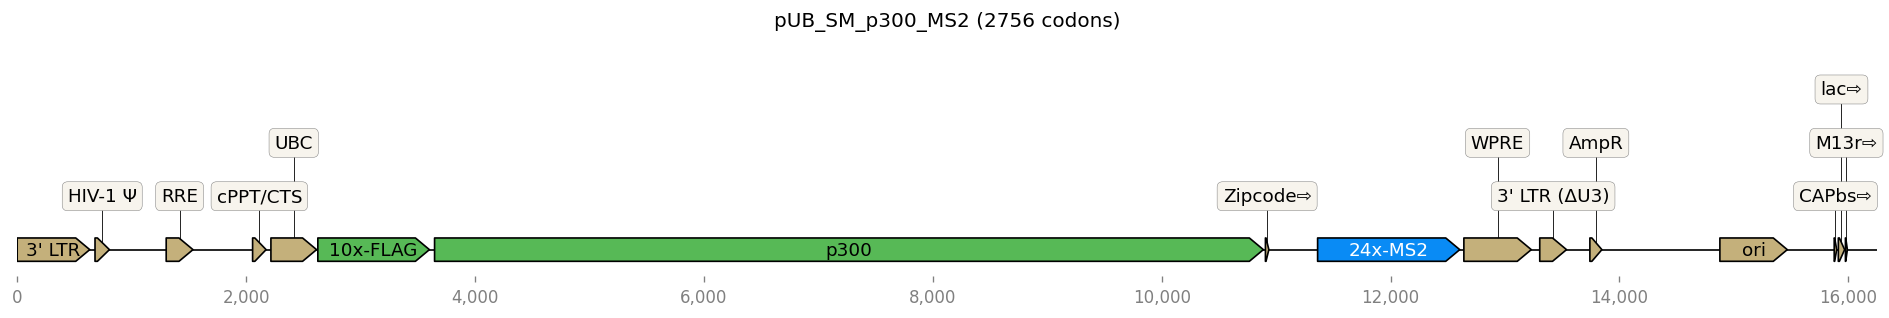

In [5]:
graphic_record = MyCustomTranslator().translate_record(gene_file_pUB_SM_p300_MS2) 
ax, _ = graphic_record.plot(figure_width=20, strand_in_label_threshold=7)
ax.set_title('pUB_SM_p300_MS2 (2756 codons)')
graphic_record.plot_legend(ax=ax, loc=1, ncol=3, frameon=False)
#ax.figure.savefig("pUB_SM_p300_MS2.png")

In [6]:
# Constant Parameters
save_as_tif = True # option to save the simulated video
save_dataframe = True # option to save the simulation output as a dataframe in format csv. 
store_videos_in_memory = True
spot_size = 7 # size of spots in pixels
spot_sigma = 1 # sigma value for a 2d-gaussian point spread function.
number_cells = 2 # Number of simulated Cell
simulation_time_in_sec = 100
simulated_RNA_intensities_method = 'random_values'
frame_selection_empty_video = 'generate_from_gaussian' # Options are: 'constant' , 'shuffle' and 'loop' 'generate_from_gaussian'
basal_intensity_in_background_video = 20000

In [7]:
list_gene_sequences = [gene_file_KDM5B_PP7,gene_file_p300_MS2] # path to gene sequences
list_label_names = [0,1] # list of strings used to generate a classification field in the output data frame
list_number_spots = [50, 50] # list of integers, where each element represents the number of spots
list_target_channels_proteins = [1, 2] # channel where the simulated protein spots will be located. Integer between 0 and 2. 
list_target_channels_mRNA = [0, 0] # channel where the simulated mRNA spots will be located. Integer between 0 and 2. 
list_diffusion_coefficients =[3, 3] # diffusion coefficients for each gene
list_elongation_rates = [10, 10] # elongation rates aa/sec
list_initiation_rates = [0.08, 0.08] # initiation rates 1/sec

In [8]:
# list_gene_sequences = gene_file_KDM5B_PP7 # path to gene sequences
# list_label_names = 0 # list of strings used to generate a classification field in the output data frame
# list_number_spots = 50 # list of integers, where each element represents the number of spots
# list_target_channels_proteins = 1 # channel where the simulated protein spots will be located. Integer between 0 and 2. 
# list_target_channels_mRNA = 0 # channel where the simulated mRNA spots will be located. Integer between 0 and 2. 
# list_diffusion_coefficients = 3 # diffusion coefficients for each gene
# list_elongation_rates = 5.33 # elongation rates aa/sec
# list_initiation_rates = 0.08 # initiation rates 1/sec

In [9]:
intensity_scale_ch0 = 1
intensity_scale_ch1 = 3
intensity_scale_ch2 = 1

In [10]:
list_videos, dataframe_simulated_cell, _ = rsp.function_simulate_cell( video_dir, 
                                                                        masks_dir, 
                                                                        list_gene_sequences,
                                                                        list_number_spots,
                                                                        list_target_channels_proteins,
                                                                        list_target_channels_mRNA, 
                                                                        list_diffusion_coefficients,
                                                                        list_label_names,
                                                                        list_elongation_rates,
                                                                        list_initiation_rates,
                                                                        number_cells = number_cells,
                                                                        simulation_time_in_sec = simulation_time_in_sec,
                                                                        step_size_in_sec = 1,
                                                                        save_as_tif = save_as_tif, 
                                                                        save_dataframe = save_dataframe,
                                                                        frame_selection_empty_video=frame_selection_empty_video,
                                                                        spot_size = spot_size,
                                                                        spot_sigma = spot_sigma,
                                                                        intensity_scale_ch0 = intensity_scale_ch0,
                                                                        intensity_scale_ch1 = intensity_scale_ch1,
                                                                        intensity_scale_ch2 = intensity_scale_ch2,
                                                                        dataframe_format = 'long',
                                                                        simulated_RNA_intensities_method=simulated_RNA_intensities_method,
                                                                        store_videos_in_memory= True,
                                                                        scale_intensity_in_base_video =False,
                                                                        basal_intensity_in_background_video=basal_intensity_in_background_video)

mean_int__ [971.0, 2124.0, 2124.0]
calculated_mean_int_in_ssa:  [4.5264 6.6144]
scales  [  97.1        1407.74125133  321.11756168]
mean_int__ [949.0, 2291.0, 2291.0]
calculated_mean_int_in_ssa:  [4.5264 6.6144]
scales  [  94.9        1518.4252386   346.36550556]
The simulation dataframes are stored here: /home/luisub/Desktop/rsnaped/notebooks/Machine_Learning/temp/dataframe_bg_generate_from_gaussian_ke_10_10_ki_0_08_0_08_kd_3_3_num_spots_50_50_time_100_num_cells_2_int0_1_int1_3_int2_1


In [11]:
dataframe_simulated_cell.head()

,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,...,SNR_red,SNR_green,SNR_blue,background_int_mean_red,background_int_mean_green,background_int_mean_blue,background_int_std_red,background_int_std_green,background_int_std_blue,Classification
0,0,0,0,125.21,1183.89,-43.44,241.36,2154.62,295.29,190,...,1.28,3.07,-0.19,1371.60,4508.28,4526.33,95.20,383.31,389.12,0
1,0,0,1,152.19,973.98,-39.34,277.92,1654.11,411.03,192,...,1.83,2.56,-0.06,1387.98,4582.79,4604.50,80.11,395.89,413.03,0
2,0,0,2,175.42,1065.92,50.29,273.75,1719.84,506.03,192,...,1.79,2.87,0.07,1382.62,4616.36,4577.58,91.39,365.31,359.46,0
3,0,0,3,164.01,1124.65,79.85,284.06,1877.52,350.90,192,...,1.67,2.81,0.15,1381.01,4581.14,4483.08,100.61,401.97,367.25,0
4,0,0,4,185.14,1230.58,-22.72,304.10,1940.79,352.96,196,...,2.14,2.30,-0.01,1412.23,4816.72,4788.45,92.29,522.61,459.98,0


In [12]:
# Loading the simulated video
selected_cell = 0
simulated_video = list_videos[selected_cell]

Dimensions in the simulated video:  (100, 512, 512, 3)
495 3573
433 33176
406 18288


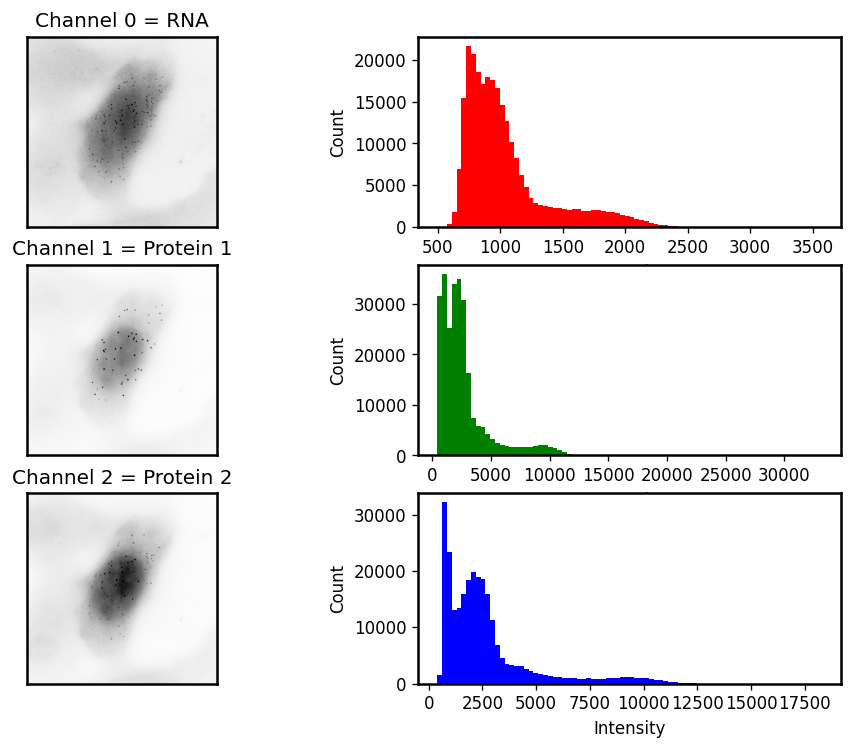

In [13]:
#@title Plotting the simulated cells
selected_time_point = 1
max_percentile=99.95
print('Dimensions in the simulated video: ', simulated_video.shape)
fig, ax = plt.subplots(3,2, figsize=(10, 7))
int_red = simulated_video[selected_time_point,:,:,0]
int_green = simulated_video[selected_time_point,:,:,1]
int_blue = simulated_video[selected_time_point,:,:,2]

print(np.min(int_red), np.max(int_red))
print(np.min(int_green), np.max(int_green))
print(np.min(int_blue), np.max(int_blue))

# Red
ax[0,0].imshow(int_red,cmap=plt.cm.Greys,vmax=np.percentile(int_red,max_percentile))
ax[0,0].set_title('Channel 0 = RNA');ax[0,0].set_xticks([]); ax[0,0].set_yticks([])
ax[0,1].hist(int_red.flatten(), bins=80,color='red')
ax[0,1].set_xlabel('Intensity'); ax[0,1].set_ylabel('Count')

# Green
ax[1,0].imshow(int_green,cmap=plt.cm.Greys,vmax=np.percentile(int_green,max_percentile))
ax[1,0].set_title('Channel 1 = Protein 1'); ax[1,0].set_xticks([]); ax[1,0].set_yticks([])
ax[1,1].hist(int_green.flatten(), bins=80,color='green')
ax[1,1].set_xlabel('Intensity'); ax[1,1].set_ylabel('Count')

# Blue
ax[2,0].imshow(int_blue,cmap=plt.cm.Greys,vmax=np.percentile(int_blue,max_percentile))
ax[2,0].set_title('Channel 2 = Protein 2'); ax[2,0].set_xticks([]); ax[2,0].set_yticks([])
ax[2,1].hist(int_blue.flatten(), bins=80,color='blue')
ax[2,1].set_xlabel('Intensity'); ax[2,1].set_ylabel('Count')
plt.show()

In [14]:
df = dataframe_simulated_cell
spot_type = 0
SNR_red_channel = df.loc[ (df['cell_number']==selected_cell) ].SNR_red.values
SNR_green_channel = df.loc[ (df['cell_number']==selected_cell) & (df['Classification']==0) ].SNR_green.values
SNR_blue_channel = df.loc[ (df['cell_number']==selected_cell)  &  (df['Classification']==1) ].SNR_blue.values


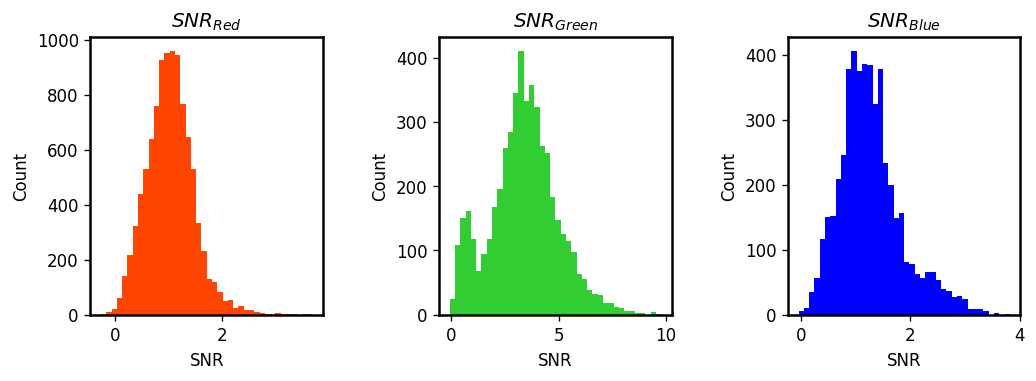

mean_SNR_red 1.02
mean_SNR_green 3.37
mean_SNR_blue 1.21


In [15]:
#@title ####Plotting SNR

# Plotting
fig, ax = plt.subplots(1,3, figsize=(10, 3))
ax[0].hist(SNR_red_channel, bins = 40, color = 'orangered')
ax[0].set_ylabel('Count')
ax[0].set_title('$SNR_{Red}$')
ax[0].set_xlabel('SNR')

ax[1].hist(SNR_green_channel, bins = 40, color = 'limegreen')
ax[1].set_ylabel('Count')
ax[1].set_title('$SNR_{Green}$')
ax[1].set_xlabel('SNR')

ax[2].hist(SNR_blue_channel, bins = 40, color = 'blue')
ax[2].set_ylabel('Count')
ax[2].set_title('$SNR_{Blue}$')
ax[2].set_xlabel('SNR')
plt.subplots_adjust(wspace=0.5, hspace=0)

plt.show()

print('mean_SNR_red', np.median(SNR_red_channel))
print('mean_SNR_green', np.median(SNR_green_channel))
print('mean_SNR_blue', np.median(SNR_blue_channel))
